In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import figure
import numpy as np
import os

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
# Curious to see how good odd makers really are. How far does the final score of NBA games differ from the closing odds? 
# Might have some uses in live betting.

# First lets create a pandas dataframe containing all of the data we have so far
path = "nba_odds"
frames = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        tmp = pd.read_csv(path+'/'+file)
        tmp['Season'] = file.split(' ')[-1][:-4]
        frames.append(tmp)
df = pd.concat(frames)
df = df.drop(columns=['1st','2nd','3rd','4th','ML','2H'])
df.reset_index(inplace=True)
df.head()

,index,Date,Rot,VH,Team,Final,Open,Close,Season
0,0,1030,501,V,Portland,97,184,189.5,2007-08
1,1,1030,502,H,SanAntonio,106,12.5,13,2007-08
2,2,1030,503,V,Utah,117,214.5,212,2007-08
3,3,1030,504,H,GoldenState,96,3,1,2007-08
4,4,1030,505,V,Houston,95,2.5,5,2007-08


In [3]:
# Cleaning the data
df.loc[1974,'Open'] = 197.5
df.loc[29095,'Open'] = 1
df.loc[29109, 'Open'] = 1

df['Open'].replace('pk', '0', inplace=True)
df['Close'].replace('pk', '0', inplace=True)
df['Open'].replace('PK', '0', inplace=True)
df['Close'].replace('PK', '0', inplace=True)
df['Final'] = pd.to_numeric(df['Final'])
df['Open'] = pd.to_numeric(df['Open'])
df['Close'] = pd.to_numeric(df['Close'])

In [4]:
# I need the actual score and odds of each game
tmp = df[0:2]
tmp

,index,Date,Rot,VH,Team,Final,Open,Close,Season
0,0,1030,501,V,Portland,97,184.0,189.5,2007-08
1,1,1030,502,H,SanAntonio,106,12.5,13.0,2007-08


In [5]:
df[2:4]

,index,Date,Rot,VH,Team,Final,Open,Close,Season
2,2,1030,503,V,Utah,117,214.5,212.0,2007-08
3,3,1030,504,H,GoldenState,96,3.0,1.0,2007-08


In [6]:
df[4:6]

,index,Date,Rot,VH,Team,Final,Open,Close,Season
4,4,1030,505,V,Houston,95,2.5,5.0,2007-08
5,5,1030,506,H,LALakers,93,191.0,199.0,2007-08


In [7]:
# Create a new dataframe where a game is only a single row
data = []
for x in range(0,df.shape[0],2):
    tmp = df[x:x+2]
    tmp.reset_index(inplace=True)
    # Look for the spread
    if tmp.loc[0,'Open'] >= 100:
        spread_open = tmp.loc[1,'Open']*-1
    else:
        spread_open = tmp.loc[0,'Open']

    if tmp.loc[0,'Close'] >= 100:
        spread_close = tmp.loc[1,'Close']*-1
    else:
        spread_close = tmp.loc[0,'Close']

    data.append([tmp.loc[0,'Team'], tmp.loc[1,'Team'], tmp.loc[0,'Final'] - tmp.loc[1,'Final'], spread_open, spread_close, tmp.loc[0,'Season']])

In [8]:
cols = ['Away Team', 'Home Team', 'Home Actual', 'Home Open', 'Home Close', 'Season']
df1 = pd.DataFrame(data,columns=cols)
df1['Diff Open'] = df1['Home Actual'] - df1['Home Open']
df1['Diff Close'] = df1['Home Actual'] - df1['Home Close']
df1.sample(10)

,Away Team,Home Team,Home Actual,Home Open,Home Close,Season,Diff Open,Diff Close
13057,LAClippers,Portland,-11,-4.5,-5.0,2018-19,-6.5,-6.0
10435,GoldenState,Toronto,6,3.0,6.0,2016-17,3.0,0.0
5365,NewYork,Detroit,23,4.0,4.0,2011-12,19.0,19.0
9439,NewOrleans,SanAntonio,-2,-3.5,-5.5,2014-15,1.5,3.5
11967,Denver,Indiana,-10,-6.5,-5.0,2017-18,-3.5,-5.0
9846,LAClippers,Minnesota,5,5.5,6.5,2014-15,-0.5,-1.5
9079,Sacramento,Memphis,-1,-6.5,-5.0,2014-15,5.5,4.0
7235,Houston,Dallas,-4,-2.0,-2.0,2012-13,-2.0,-2.0
2940,Portland,Indiana,11,5.0,4.5,2009-10,6.0,6.5
12617,Dallas,Brooklyn,-8,-1.5,-4.5,2017-18,-6.5,-3.5


C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


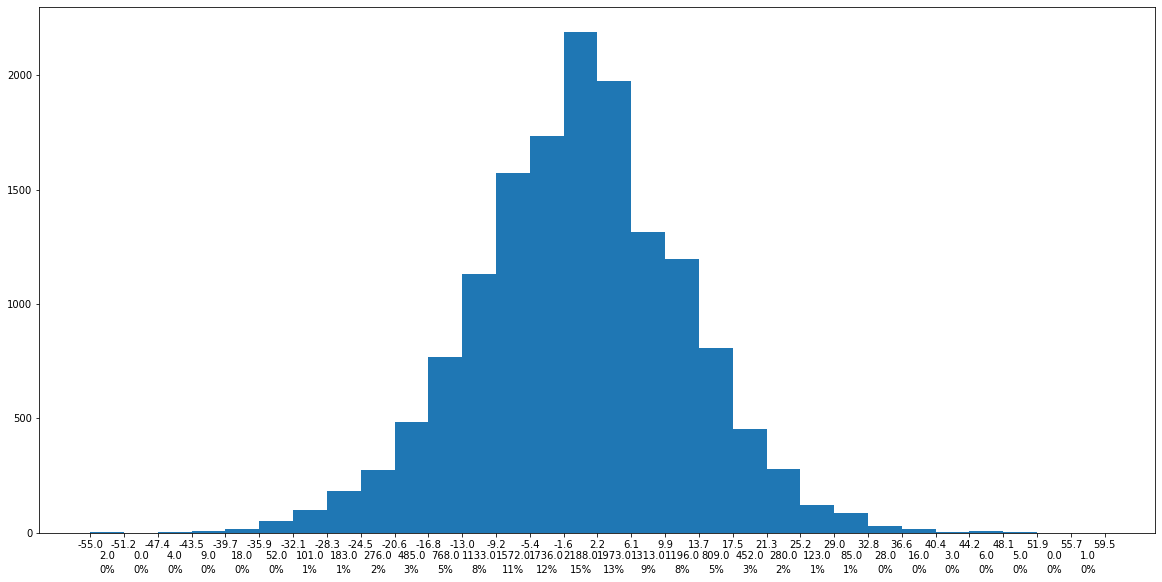

In [9]:
diff = df1['Diff Close'].tolist()
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(diff, bins = 30)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
plt.show()

In [10]:
for key, value in sorted(d.items(), key=lambda x: x[0]): 
    print("{} : {}".format(key, value))

NameError: name 'd' is not defined

In [11]:
def find_per(low, hi, diff):
    # Create a python dict so we can do some more analysis
    d = {}
    for x in diff:
        if x in d:
            d[x] += 1
        else:
            d[x] = 1
    
    # What % of games fall between certain values
    diff_low = low
    diff_hi = hi
    tmp = 0
    total = 0
    for k in d:
        total += d[k]
        if k >= diff_low and k <= diff_hi:
            tmp += d[k]


    print("{:.2f}% of games had a final score that fell between {} and {} of the closing odds".format((tmp/total)*100,diff_low,diff_hi))

In [13]:
find_per(-100,10,diff)

80.96% of games had a final score that fell between -100 and 10 of the closing odds


In [14]:
find_per(-100,5,diff)

67.75% of games had a final score that fell between -100 and 5 of the closing odds


In [15]:
find_per(-100,3,diff)

60.95% of games had a final score that fell between -100 and 3 of the closing odds


In [39]:
# Does this really mean that if I can find a live line that favors the home team by 5 more pts than the 
# closing line, I have a 67.75% chance of winning

# Going to test it with the live odds data I scraped

# I feel like a possible flaw is that games where that live odd appears account for more of the 32.25% losses

In [16]:
# What I need are the closing home line, what the max line was in favor of the home team, 
# the odds of that line, and the actual score

# First lets create a pandas dataframe containing all of the data we have so far
path = "games"
frames = []
for file in os.listdir(path):
    if file.endswith(".csv"):
        tmp = pd.read_csv(path+'/'+file)
        tmp['Actual'] = tmp['Away Score'] - tmp['Home Score']
        tmp['Diff'] = tmp['Actual'] - tmp['Home Line Open']
        frames.append(tmp.loc[tmp['Home Odds'] >= -140].nlargest(1,'Home Line'))
        
df2 = pd.concat(frames)
df2.reset_index(inplace=True)
df2.drop(columns=['Book','Away Line','Away Odds','Away Line Open'],inplace=True)
df2.head()

,index,Time,Away Team,Home Team,Home Line,Home Odds,Home Score,Away Score,Home Line Open,Actual,Diff
0,388,1/4 8:35:48 am,Atlanta Hawks,Boston Celtics,2.0,-115,109,106,-10.5,-3,7.5
1,368,2/8 9:55:28 am,Atlanta Hawks,Boston Celtics,-5.0,-112,112,107,-13.0,-5,8.0
2,195,12/22 8:32:02 am,Atlanta Hawks,Brooklyn Nets,10.0,-116,122,112,-7.5,-10,-2.5
3,407,1/13 7:09:23 am,Atlanta Hawks,Brooklyn Nets,-8.5,-107,108,86,-8.5,-22,-13.5
4,12,12/9 8:01:06 am,Atlanta Hawks,Charlotte Hornets,14.5,-116,107,122,-2.0,15,17.0


In [17]:
df2['Diff'].mean()

-0.04398447606727038

In [18]:
(df2['Home Line Open']+5 > df2['Actual']).value_counts()

True     496
False    277
dtype: int64

In [19]:
441/(690)

# So betting the home opening line + 5 wins 64% of bets. Not far from the 67.75% we saw above. 
# However how many of these games actually had live odds like that? 

0.6391304347826087

In [20]:
# Find all the games where the highest live home odds was at least the home opening line + 5
# The games not included here are games where the favorite team probably lead the entire time. Thus no good live odds
tmp = df2.loc[df2['Home Line'] >= df2['Home Line Open'] + 5]
print(tmp.shape)
tmp.head()

(496, 11)


,index,Time,Away Team,Home Team,Home Line,Home Odds,Home Score,Away Score,Home Line Open,Actual,Diff
0,388,1/4 8:35:48 am,Atlanta Hawks,Boston Celtics,2.0,-115,109,106,-10.5,-3,7.5
1,368,2/8 9:55:28 am,Atlanta Hawks,Boston Celtics,-5.0,-112,112,107,-13.0,-5,8.0
2,195,12/22 8:32:02 am,Atlanta Hawks,Brooklyn Nets,10.0,-116,122,112,-7.5,-10,-2.5
4,12,12/9 8:01:06 am,Atlanta Hawks,Charlotte Hornets,14.5,-116,107,122,-2.0,15,17.0
5,377,12/12 9:27:47 am,Atlanta Hawks,Chicago Bulls,-1.0,-120,136,102,-6.5,-34,-27.5


In [21]:
# Lets find how many bets would result in a win if I bet at the highest home line
# If the home line is greater than the actual result, the bet won
tmp["Win"] = tmp['Home Line'] > tmp['Actual']
print(tmp.Win.value_counts())
print('Win %: ', tmp.Win.value_counts()[True]*100/(tmp.Win.value_counts()[True]+tmp.Win.value_counts()[False]))
print('Diff: ',tmp['Diff'].mean())

True     399
False     97
Name: Win, dtype: int64
Win %:  80.44354838709677
Diff:  5.047379032258065


C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
# 80% of bets would result in a win if I bet at the highest home odds. Of course, during a live game I would never
# know when the home odds actually are at its highest (use ML?)

# The diff of 5.2 means that in these games, the home team lost by 5.2pts more than the opening line

# Very interesting correlation
# Games where the highest live home odds are >= X usually lose by Xpts more than the opening line

In [22]:
# 80% of bets would result in a win if I bet at the highest home odds. Of course, during a live game I would never
# know when the home odds actually are at its highest

# What about bets done at the opening line + 5?
tmp["Win"] = tmp['Home Line Open'] + 5 > tmp['Actual']
print(tmp.Win.value_counts())
print('Win %: ', tmp.Win.value_counts()[True]*100/(tmp.Win.value_counts()[True]+tmp.Win.value_counts()[False]))
print('Diff: ',tmp['Diff'].mean())

False    262
True     234
Name: Win, dtype: int64
Win %:  47.17741935483871
Diff:  5.047379032258065


C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [143]:
# Yikes 47%. So just betting on the home team line when it is 5pts better when it opened is NOT a winning strategy.
# This might actually need deep learning. I don't see any trends right now.

In [145]:
# I also want to see what the different histograms look like for different closing odd ranges
# When the odds range from -1 to -3 should be different than when the home team is favored -12 to -15

(5432, 8)
66.79% of games had a final score that fell between -100 and 5 of the closing odds


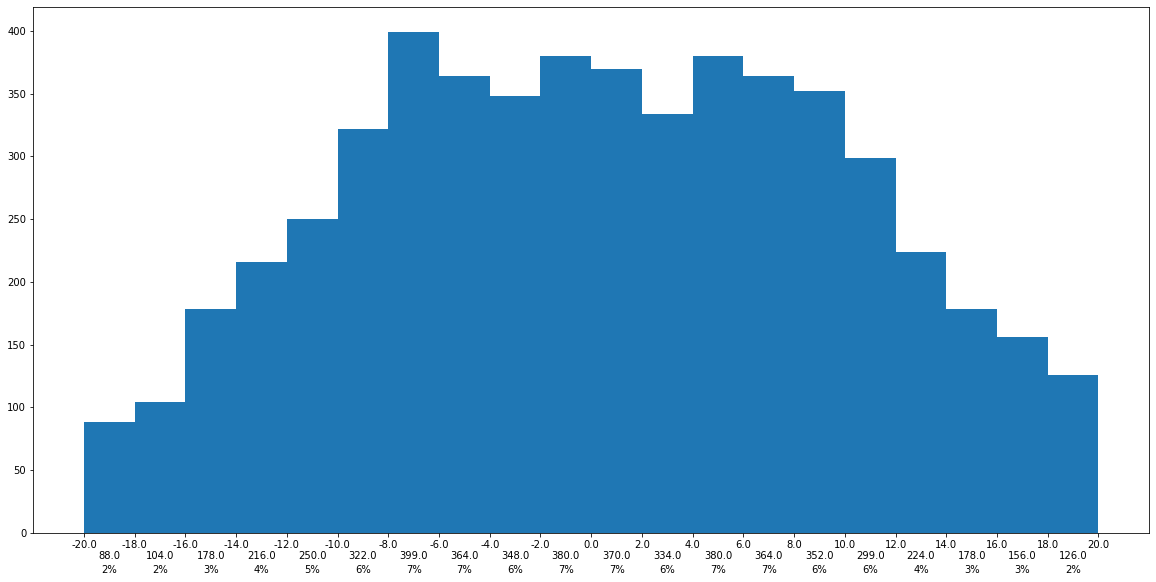

In [25]:
tmp = df1.loc[(abs(df1['Home Close']) >= 0) & (abs(df1['Home Close']) <= 4.5)]
tmp = tmp.loc[(tmp['Diff Close'] >= -20) & (tmp['Diff Close'] <= 20)]
print(tmp.shape)
diff = tmp['Diff Close'].tolist()
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(diff, bins = 20)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
find_per(-100,5,diff)
plt.show()

(6403, 8)
71.62% of games had a final score that fell between -100 and 5 of the closing odds


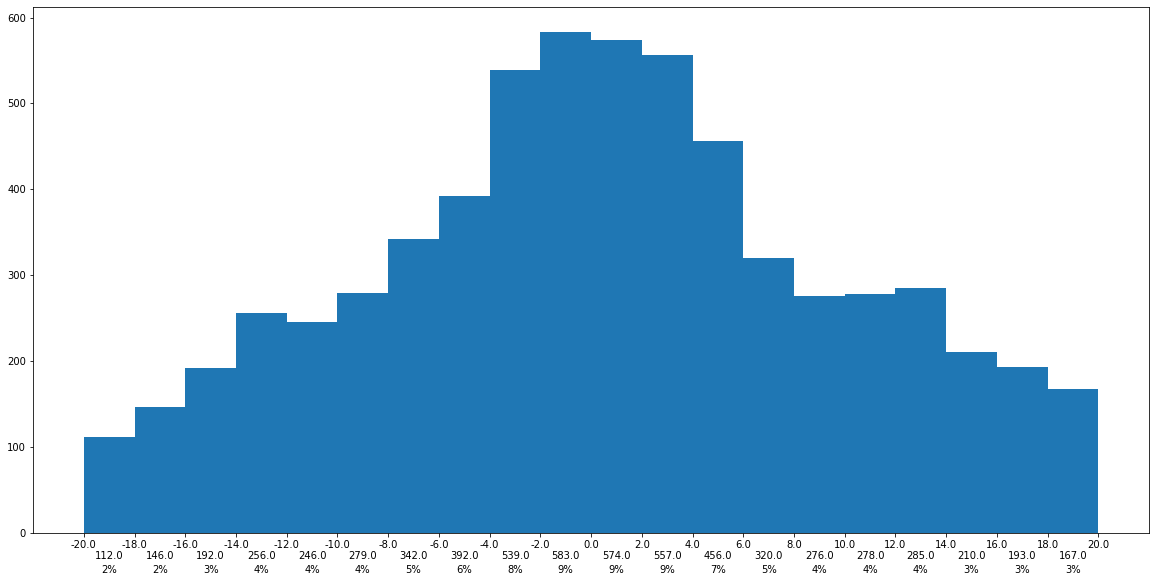

In [26]:
tmp = df1.loc[(abs(df1['Home Close']) >= 5) & (abs(df1['Home Close']) <= 10.5)]
tmp = tmp.loc[(tmp['Diff Close'] >= -20) & (tmp['Diff Close'] <= 20)]
print(tmp.shape)
diff = tmp['Diff Close'].tolist()
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(diff, bins = 20)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
find_per(-100,5,diff)
plt.show()

(1894, 8)
69.64% of games had a final score that fell between -100 and 5 of the closing odds


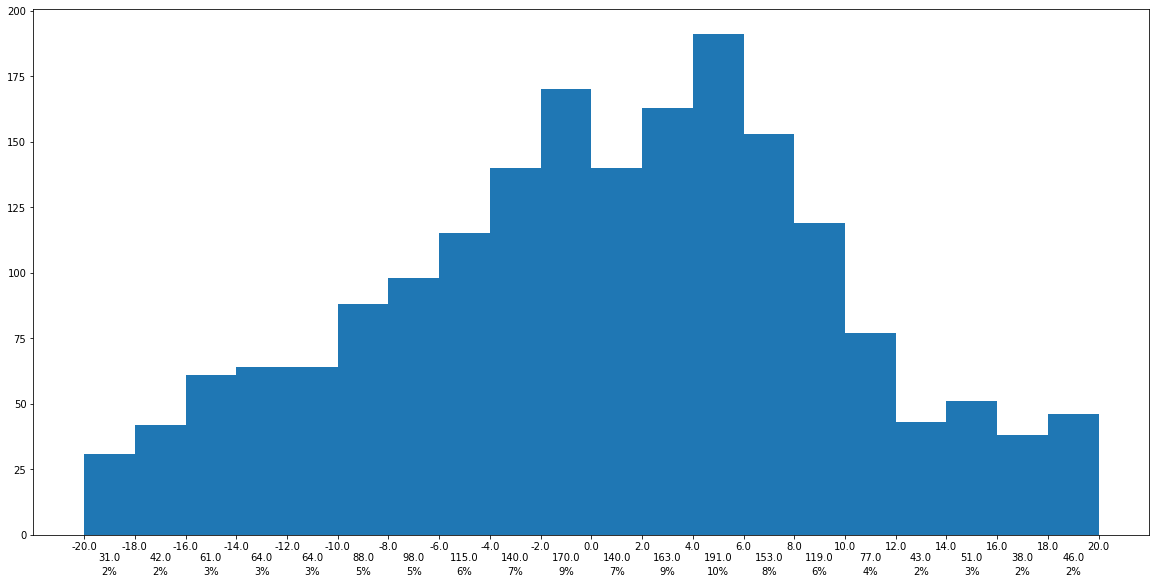

In [27]:
tmp = df1.loc[(abs(df1['Home Close']) >= 10.5)]
tmp = tmp.loc[(tmp['Diff Close'] >= -20) & (tmp['Diff Close'] <= 20)]
print(tmp.shape)
diff = tmp['Diff Close'].tolist()
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(diff, bins = 20)
ax.set_xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))

# Label the raw counts and the percentages below the x-axis...
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.0f%%' % (100 * float(count) / counts.sum())
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)
find_per(-100,5,diff)
plt.show()

In [175]:
# Another interesting finding. Apparently bookmakers are more accurate at 
# predicting games having high spreads (-13) than low spread (PK) games

In [31]:
# Find all the games where the highest live home odds was at least the home opening line + 5
# The games not included here are games where the favorite team probably lead the entire time. Thus no good live odds
tmp = df2.loc[df2['Home Line'] >= df2['Home Line Open'] + 10]
print(tmp.shape)
tmp.head()

(293, 11)


,index,Time,Away Team,Home Team,Home Line,Home Odds,Home Score,Away Score,Home Line Open,Actual,Diff
0,388,1/4 8:35:48 am,Atlanta Hawks,Boston Celtics,2.0,-115,109,106,-10.5,-3,7.5
2,195,12/22 8:32:02 am,Atlanta Hawks,Brooklyn Nets,10.0,-116,122,112,-7.5,-10,-2.5
4,12,12/9 8:01:06 am,Atlanta Hawks,Charlotte Hornets,14.5,-116,107,122,-2.0,15,17.0
9,113,11/13 11:45:45 am,Atlanta Hawks,Denver Nuggets,4.5,-112,121,125,-10.0,4,14.0
10,4,10/25 9:16:31 am,Atlanta Hawks,Detroit Pistons,10.5,100,100,117,-1.5,17,18.5


In [32]:
# Lets find how many bets would result in a win if I bet at the highest home line
# If the home line is greater than the actual result, the bet won
tmp["Win"] = tmp['Home Line'] > tmp['Actual']
print(tmp.Win.value_counts())
print('Win %: ', tmp.Win.value_counts()[True]*100/(tmp.Win.value_counts()[True]+tmp.Win.value_counts()[False]))
print('Diff: ',tmp['Diff'].mean())

True     223
False     70
Name: Win, dtype: int64
Win %:  76.10921501706484
Diff:  9.709897610921502


C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
# 80% of bets would result in a win if I bet at the highest home odds. Of course, during a live game I would never
# know when the home odds actually are at its highest

# What about bets done at the opening line + 5?
tmp["Win"] = tmp['Home Line Open'] + 10 > tmp['Actual']
print(tmp.Win.value_counts())
print('Win %: ', tmp.Win.value_counts()[True]*100/(tmp.Win.value_counts()[True]+tmp.Win.value_counts()[False]))
print('Diff: ',tmp['Diff'].mean())

False    149
True     144
Name: Win, dtype: int64
Win %:  49.14675767918089
Diff:  9.709897610921502


C:\Users\rcantero\Anaconda3\envs\live\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
